In [21]:
# installations
!pip install numpy
!pip install pandas
!pip install scipy

In [93]:
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

# Running a test
The following chunk runs a lightweight version of the experiment once, with only a handful of users.
At each round, the model gets fitted to every user in the dataset and a regret score is calculated.
At the end of all rounds (by default 100 rounds) the minimum cumulative regret indicates, which model performs best.
According to the source paper, *ts-seg-pessimistic* performs best on the offline experiment. Hence, they tested this models performance in a cascade versus non-cascade offline experiment, in which case the *ts-seg-pessimistic cascade* model performed best. This model also caused the highest display-to-stream gain.
All featured tests' results showed statistical significance at the 1% level. However, the paper does not state how those statistical tests were conducted.


In [23]:
# small dataset, all policies
# !python main.py --users_path data/user_features_small.csv --policies random,etc-seg-explore,etc-seg-exploit,epsilon-greedy-explore,epsilon-greedy-exploit,kl-ucb-seg,ts-seg-naive,ts-seg-pessimistic,ts-lin-naive,ts-lin-pessimistic --n_users_per_round 9 --output_path general_experiment_results.json
# !python plot_results.py --data_path general_experiment_results.json


In [24]:
# full dataset, two policies
# !python main.py --policies random,ts-seg-pessimistic --print_every 5 --output_path general_experiment_results.json
# !python plot_results.py --data_path general_experiment_results.json

# My suggestion for reproducing tests
We can reproduce the full offline experiment. We just need to find a way to compare results.
https://machinelearningmastery.com/statistical-significance-tests-for-comparing-machine-learning-algorithms/
According to this paper, it is common to do a 10-fold cross validation on the dataset at hand and grab the mean/median success metric of each model as a statistic for that model. We would then have the following hypotheses:
 * h0: there is no difference in model performances, i.e. ts-seg-pessimistic (cascade) performs just as well as the other models, i.e. the lower cumulative regret of the tests are due to chance
  * h1: there is a difference in model performances, i.e. ts-seg-pessimistic (cascade) outperforms the other models

### Does the original code cross-validate?
No, but something different. The argument *n_users_per_round* (default 20.000, 1% of full dataset) states, how many users actually get recommended anything in any round. That means that the actual dataset never changes for every time you run the experiment, but the sample on which you fit and evaluate the model changes on every round.
According to Brownlee (2018, https://machinelearningmastery.com/statistical-significance-tests-for-comparing-machine-learning-algorithms/), this testing behaviour violates a key assumption of the Student's t-test, which is independency of observations in each sample per round.
My suggestion for fixing this. Run the full experiment k (10) times and give the program either 10% of the data to work on, while either continuing to let it use a sample of 20.000 users or even telling it not to resample anything, but rather work on the whole data. Instead of rewriting the source code to include cross-validation, I will split the users dataset itself into k samples and run the whole main.py file k times, with different arguments each time, i.e. changing the results-output-filename.
The only rewriting I will do, is putting the main workflow of the main.py file into a separate main() function with arguments passed in python rather than from the command line, so I can execute it using this notebook.


In [25]:
from experiment import run_experiment

# test run of the new experiment.py
run_exemplary_experiment = False

if run_exemplary_experiment:
        run_experiment(
                users_path="data/user_features.csv",
                playlists_path="data/playlist_features.csv",
                output_path="results.json",
                policies="random,ts-seg-naive",
                n_recos=12,
                l_init=3,
                n_users_per_round=20000,
                n_rounds=100,
                print_every=10,
        )

In [26]:
def split_dataset(data_filename, k):
        # grabs a datafile from the folder "data/"
        # randomly splits the dataset into k smaller sets of equal size
        # saves them in the folder "data/split/"

        with open(f"data/{data_filename}", "r") as f:
                full = np.array(f.readlines())

        data_filename, suffix = data_filename.split(".")

        # header row should be separate
        header_row, full = full[0], full[0:]

        N = len(full) # number of all rows
        indices = np.array(list((range(N)))) # numbers from 0 to N
        n = N // k # number of rows per k

        print(f"Splitting {N} rows from {data_filename}.{suffix} into {k} files with {n} rows each ...")

        for i in range(k):
                # get random row numbers from 0 to the length of indices (starts at N)
                random_indices = np.random.choice(len(indices), n, replace=False)
                # grab random row numbers of the remaining ones
                sample_indices = indices[random_indices]
                # remove the selected row numbers from the indices list
                indices = np.delete(indices, random_indices)
                # create a sample
                sample = full[sample_indices]
                # add the header row
                sample = np.append(header_row, sample)
                # save the sample
                print(f"\t saving file number {i}: {sample_indices}")
                f = f"data/split/{data_filename}_{i}.{suffix}"
                with open(f, "w") as f:
                        f.writelines(list(sample))


        print(f"All done. {len(indices)} users remain unsaved: {indices}")
        print()
        del full
        del indices
        del sample




# Preparing k datasets
data_filename = "user_features.csv"
data_filename = "user_features_s.csv"

k = 10

#split_dataset(data_filename, k)

### Data for testing
* data/split/: small data
* data/splitL: big data

In [118]:
from experiment import run_experiment
all_policies = "random,etc-seg-explore,etc-seg-exploit,epsilon-greedy-explore,epsilon-greedy-exploit,kl-ucb-seg,ts-seg-naive,ts-seg-pessimistic,ts-lin-naive,ts-lin-pessimistic"

def run_k_experiments(
        input_samples_dir,
        output_dir="output",
        n_users_per_round=None,
        print_every=5,
        policies=all_policies
):
        input_samples_dir = input_samples_dir.strip("/")
        output_dir = output_dir.strip("/")

        files = os.listdir(input_samples_dir)
        print(f"Running {len(files)} experiments with input files from {input_samples_dir}")
        for f in files:
                try:
                        run_experiment(
                                users_path=f"{input_samples_dir}/{f}",
                                playlists_path="data/playlist_features.csv",
                                output_path=f"{output_dir}/results_{f}.json",
                                policies=policies,
                                n_recos=12,
                                l_init=3,
                                n_users_per_round=n_users_per_round,
                                n_rounds=100,
                                print_every=print_every,
                        )
                except TypeError as e:
                        print(f"Experiment failed on input file {f}", e)
                except KeyError as e:
                        print(f"Experiment failed on input file {f}", e)
        print("Experiments finished.")


## Experiment 1
Running all policies on all users and seeing which policy performs best
We run this on 10 samples of the original data

In [100]:
# run the experiment with all policies & all users on each round
# then we can compare the policies' accuracies

input_samples_dir = "data/split"
output_dir = "data/t"
n_users_per_round = None

run_k_experiments(input_samples_dir, output_dir, n_users_per_round)

INFO:experiment:LOADING DATA
INFO:experiment:Loading playlist data
INFO:experiment:Loading user data
 



Running 11 experiments with input files from data/split


INFO:experiment:SETTING UP SIMULATION ENVIRONMENT
INFO:experiment:for 9749 users, 862 playlists, 12 recommendations per carousel 
 

INFO:experiment:SETTING UP POLICIES
INFO:experiment:Policies to evaluate: random,etc-seg-explore,etc-seg-exploit,epsilon-greedy-explore,epsilon-greedy-exploit,kl-ucb-seg,ts-seg-naive,ts-seg-pessimistic,ts-lin-naive,ts-lin-pessimistic 
 

INFO:experiment:STARTING SIMULATIONS
INFO:experiment:for 100 rounds, with 9749 users per round (randomly drawn with replacement)
 



KeyboardInterrupt: 

### Results of experiment 1
- 8 samples with ~1000 users each
- all policies

In [104]:
## Loading results (cumulative regret)
def get_results(results_location, wide_to_long=False):
        results = None
        for f in [f for f in os.listdir(results_location) if "store" not in f.lower()]:
                with open(f"{results_location}/{f}", "r") as f:
                        res = json.load(f)
                res = {key: [value[-1]] for key, value in res.items()}
                res = pd.DataFrame.from_dict(res)
                if results is None:
                        results = res
                else:
                        results = results.append(res)

        results = results.reset_index().drop("index", 1)

        if wide_to_long:
                results = results.unstack().reset_index()
                results = results.drop("level_1", 1)
                results.columns = ["policy", "regret"]

        return results


In [47]:
results_location = "output/s1"
experiment_results = get_results(results_location, wide_to_long=True)
experiment_results.sample(10)

,policy,regret
15,etc-seg-explore,606201.180559
74,ts-lin-pessimistic,185098.800701
75,ts-lin-pessimistic,176364.240031
25,epsilon-greedy-explore,153131.255530
39,epsilon-greedy-exploit,173679.180559
36,epsilon-greedy-exploit,177888.583938
41,kl-ucb-seg,365022.255530
55,ts-seg-naive,181350.180559
64,ts-lin-naive,172816.432176
24,epsilon-greedy-explore,153611.432176


                               regret
policy                               
ts-seg-pessimistic      110459.619532
epsilon-greedy-explore  153890.244532
ts-lin-naive            178054.869532
ts-lin-pessimistic      178082.119532
epsilon-greedy-exploit  180424.119532
ts-seg-naive            182257.994532
etc-seg-exploit         201066.244532
kl-ucb-seg              361027.744532
etc-seg-explore         604367.369532
random                  637184.619532


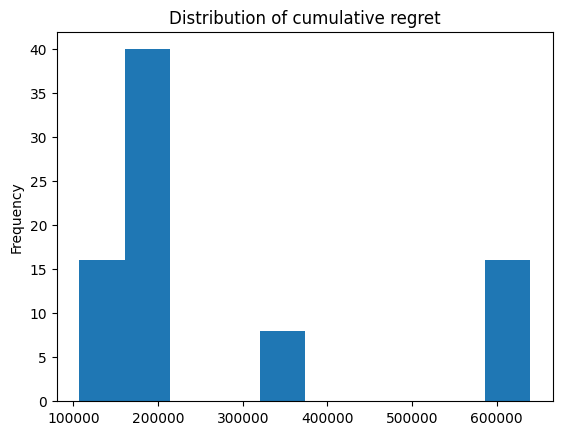

In [46]:
experiment_results.regret.plot(kind='hist', title='Distribution of cumulative regret')
results_mean = experiment_results.groupby("policy").mean().sort_values("regret")
print(results_mean)

In [31]:
top_policy = results_mean.iloc[0]
global_mean = results_mean.mean()

print("Best performing policy:", top_policy.name)
print("Best performing policy mean:", top_policy[0])
print("Global mean regret:", global_mean[0])


                               regret
policy                               
ts-seg-pessimistic      110459.619532
epsilon-greedy-explore  153890.244532
ts-lin-naive            178054.869532
ts-lin-pessimistic      178082.119532
epsilon-greedy-exploit  180424.119532
ts-seg-naive            182257.994532
etc-seg-exploit         201066.244532
kl-ucb-seg              361027.744532
etc-seg-explore         604367.369532
random                  637184.619532
Best performing policy: ts-seg-pessimistic
Best performing policy mean: 110459.61953232295
Global mean regret: 278681.494532323


In [105]:

target_policy = "ts-seg-pessimistic"
data = experiment_results

def test_mean_mann(data, target_policy):

        target_sample = data[data.policy == target_policy].regret
        rest_sample = data[data.policy != target_policy].regret

        global_mean = data[data.policy != target_policy].regret.mean()
        target_mean = data[data.policy == target_policy].regret.mean()

        smaller = global_mean < target_mean
        print("Global mean\t", "<" if smaller else ">", "\tTarget mean")
        print(round(global_mean, 2), "\t", "<" if smaller else ">",  "\t", round(target_mean, 2))



        stat, p = mannwhitneyu(target_sample, rest_sample)
        print(f"p-value: {p}")
        alpha = .05
        significant = p < alpha
        print("—>", "reject H0" if significant else "accept h=")
        print("—>", f"the target policy has a different distribution from the others"
                        if significant
                        else "the target policy has the same distribution as the others")


        fig = plt.figure()
        ax = fig.add_subplot()

        data.regret.plot(kind='hist', title='Population distribution')
        plt.axvline(target_mean, color="yellow")
        ax.set_xlabel(f"Test result {'not' if not significant else ''}significant at significance level of p < {alpha}")


Global mean	 > 	Target mean
297372.81 	 > 	 110459.62
p-value: 6.899516815280735e-11
—> reject H0
—> the target policy has a different distribution from the others


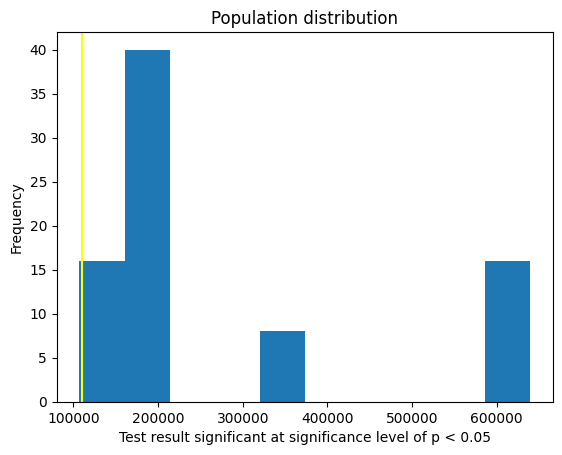

In [98]:
test_mean_mann(data, target_policy)

## Experiment 2
Finding out whether cascading makes the models better

Original command:
`python main.py --policies epsilon-greedy-explore,epsilon-greedy-explore-no-cascade,ts-seg-pessimistic,ts-seg-pessimistic-no-cascade --print_every 5 --output_path cascade_experiment_results.json`
`python plot_results.py --data_path cascade_experiment_results.json`

In [119]:
input_samples_dir = "data/split"
output_dir = "output/casc"
n_users_per_round = None
policies = "epsilon-greedy-explore,epsilon-greedy-explore-no-cascade,ts-seg-pessimistic,ts-seg-pessimistic-no-cascade"

run_k_experiments(input_samples_dir, output_dir, n_users_per_round, policies=policies)


INFO:experiment:LOADING DATA
INFO:experiment:Loading playlist data
INFO:experiment:Loading user data
 



Running 11 experiments with input files from data/split


INFO:experiment:SETTING UP SIMULATION ENVIRONMENT
INFO:experiment:for 9749 users, 862 playlists, 12 recommendations per carousel 
 

INFO:experiment:SETTING UP POLICIES
INFO:experiment:Policies to evaluate: epsilon-greedy-explore,epsilon-greedy-explore-no-cascade,ts-seg-pessimistic,ts-seg-pessimistic-no-cascade 
 

INFO:experiment:STARTING SIMULATIONS
INFO:experiment:for 100 rounds, with 9749 users per round (randomly drawn with replacement)
 

INFO:experiment:Round: 1/100. Elapsed time: 5.907509 sec.
INFO:experiment:Cumulative regrets: 
	epsilon-greedy-explore : 6411.139055433716
	epsilon-greedy-explore-no-cascade : 6351.139055433716
	ts-seg-pessimistic : 6465.139055433716
	ts-seg-pessimistic-no-cascade : 6373.139055433716 

INFO:experiment:Round: 5/100. Elapsed time: 28.211489 sec.
INFO:experiment:Cumulative regrets: 
	epsilon-greedy-explore : 21659.225752518454
	epsilon-greedy-explore-no-cascade : 21100.225752518454
	ts-seg-pessimistic : 22939.225752518454
	ts-seg-pessimistic-no-cas

Experiment failed on input file user_features_s_2.csv can't multiply sequence by non-int of type 'float'


INFO:experiment:SETTING UP SIMULATION ENVIRONMENT
INFO:experiment:for 9749 users, 862 playlists, 12 recommendations per carousel 
 

INFO:experiment:SETTING UP POLICIES
INFO:experiment:Policies to evaluate: epsilon-greedy-explore,epsilon-greedy-explore-no-cascade,ts-seg-pessimistic,ts-seg-pessimistic-no-cascade 
 

INFO:experiment:STARTING SIMULATIONS
INFO:experiment:for 100 rounds, with 9749 users per round (randomly drawn with replacement)
 

INFO:experiment:Round: 1/100. Elapsed time: 6.782644 sec.
INFO:experiment:Cumulative regrets: 
	epsilon-greedy-explore : 6393.408518805698
	epsilon-greedy-explore-no-cascade : 6409.408518805698
	ts-seg-pessimistic : 6356.408518805698
	ts-seg-pessimistic-no-cascade : 6349.408518805698 

INFO:experiment:Round: 5/100. Elapsed time: 32.562555 sec.
INFO:experiment:Cumulative regrets: 
	epsilon-greedy-explore : 21357.48797956182
	epsilon-greedy-explore-no-cascade : 21331.48797956182
	ts-seg-pessimistic : 22583.48797956182
	ts-seg-pessimistic-no-cascad

Experiment failed on input file .DS_Store "['segment'] not found in axis"


INFO:experiment:SETTING UP SIMULATION ENVIRONMENT
INFO:experiment:for 9749 users, 862 playlists, 12 recommendations per carousel 
 

INFO:experiment:SETTING UP POLICIES
INFO:experiment:Policies to evaluate: epsilon-greedy-explore,epsilon-greedy-explore-no-cascade,ts-seg-pessimistic,ts-seg-pessimistic-no-cascade 
 

INFO:experiment:STARTING SIMULATIONS
INFO:experiment:for 100 rounds, with 9749 users per round (randomly drawn with replacement)
 

INFO:experiment:Round: 1/100. Elapsed time: 6.647718 sec.
INFO:experiment:Cumulative regrets: 
	epsilon-greedy-explore : 6383.080206085813
	epsilon-greedy-explore-no-cascade : 6328.080206085813
	ts-seg-pessimistic : 6366.080206085813
	ts-seg-pessimistic-no-cascade : 6324.080206085813 

INFO:experiment:Round: 5/100. Elapsed time: 31.778789 sec.
INFO:experiment:Cumulative regrets: 
	epsilon-greedy-explore : 21294.94775553768
	epsilon-greedy-explore-no-cascade : 21423.94775553768
	ts-seg-pessimistic : 22478.94775553768
	ts-seg-pessimistic-no-cascad

Experiment failed on input file user_features_s_6.csv can't multiply sequence by non-int of type 'float'


INFO:experiment:SETTING UP SIMULATION ENVIRONMENT
INFO:experiment:for 9749 users, 862 playlists, 12 recommendations per carousel 
 

INFO:experiment:SETTING UP POLICIES
INFO:experiment:Policies to evaluate: epsilon-greedy-explore,epsilon-greedy-explore-no-cascade,ts-seg-pessimistic,ts-seg-pessimistic-no-cascade 
 

INFO:experiment:STARTING SIMULATIONS
INFO:experiment:for 100 rounds, with 9749 users per round (randomly drawn with replacement)
 

INFO:experiment:Round: 1/100. Elapsed time: 6.768770 sec.
INFO:experiment:Cumulative regrets: 
	epsilon-greedy-explore : 6348.445876739916
	epsilon-greedy-explore-no-cascade : 6397.445876739916
	ts-seg-pessimistic : 6427.445876739916
	ts-seg-pessimistic-no-cascade : 6377.445876739916 

INFO:experiment:Round: 5/100. Elapsed time: 32.518328 sec.
INFO:experiment:Cumulative regrets: 
	epsilon-greedy-explore : 21402.192834486217
	epsilon-greedy-explore-no-cascade : 21439.192834486217
	ts-seg-pessimistic : 22337.192834486217
	ts-seg-pessimistic-no-cas

Experiments finished.
